In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
import emcee
rcParams['figure.figsize'] = 12, 9

# Гипотезы

Любое утверждение касательно наблюдаемой случайной величины является гипотезой. Различают два вида гипотез
* Простая гипотеза - предположение о каком-то конкретном законе распределения (то есть все параметры считаются известными)
* Сложная гипотеза - предположение о том, что случайная величина принадлежит некому семейству распределений (есть незафиксированные параметры)

Обычно вводят гипотезу $H_0$ - некое простое утверждение. В противовес ей вводят гипотезу $H_1$ - противоположное утверждение. Для проверки гипотезы вводят некий критерий $\lambda$, согласно которому $H_0$ принимается или отвергается в пользу $H_1$. 

Критерий определяет критическую область значений $\mathbf{X}$, при которых мы отвергаем гипотезу $H_0$ в пользу $H_1$. Обозначим эту область $W$, Пространство всех возможных значений $\mathbf{X}$ будем обозначать $\Omega$. Следовательно область $\Omega - W$ - это допустимая область, где гипотеза $H_0$ не может быть отвергнута.

Размер критической области обычно подбирается таким образом, чтобы вероятность попадания критерия в эту область равнялась желаемому уровню значимости

$$
P(\lambda \subset W | H_0) = \alpha 
$$

Фактически, $\alpha$ определяет вероятность того, что мы отвергаем гипотезу, когда она верна. Это называется ошибкой первого рода.

При этом вероятность попадания критерия в допустимую область в случае предположения гипотезы $H_1$, называются мощностью критерия

$$
P(\Lambda \subset W| H_1) = 1 - \beta
$$

Данная величина показывает вероятность ошибки, в случае принятия гипотезы $H_0$, в то время как верна гипотеза $H_1$. Это называется ошибкой второго рода. 

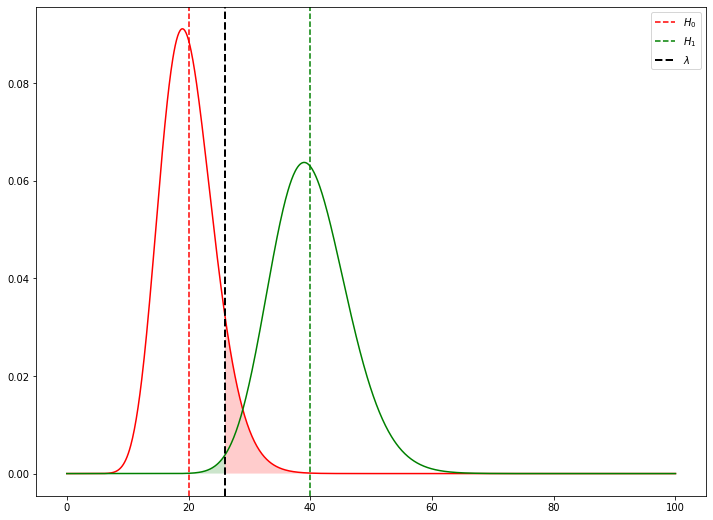

In [7]:
from scipy.stats import gamma
import numpy as np

# Просто отрисовка распределения в зависимости от гипотезы
def Hypo(m, m0, label, xmin=0, xmax=100, fc='g'):
    x = np.linspace(xmin, xmax, 1000)
    f = gamma(m)
    plt.plot(x, f.pdf(x), c=fc)
    
    if m0 > 0:
        xs = np.linspace(m0, xmax, 1000)
    else:
        xs = np.linspace(xmin, -m0, 1000)
        
    plt.axvline(m, c=fc, ls='--', label=label)
    plt.fill(np.concatenate([xs, xs[::-1]]),
         np.concatenate([f.pdf(xs), np.zeros(xs.shape)]),
         alpha=.2, fc=fc)
    
m0 = 26
Hypo(20, m0, "$H_0$", fc='r')
Hypo(40, -m0, "$H_1$", fc='g')
plt.axvline(m0, c='k', ls='--', lw=2, label="$\lambda$");
plt.legend()
plt.show()

В общем случае, критическая область не единственна. Очевидным решением будет является выбрать такую критическую область, для которой $\beta$ минимально, что эквивалентно максимальной мощности.

В настоящее время наряду с пороговым значением критерия вводят так называемое $P$-value, которое является просто вероятностью встретить значение критерия больше наблюдаемого (для случая одностороннего критерия)

$$
P(k > k_{obs}) = \int_{k_{obs}}^{\infty} f(k)\,dk
$$

Таким образом, если $P$-value меньше, чем $\alpha$, то мы вынуждены отвергнуть нулевую гипотезу. Нередко $P$-value указывают в $Z$ масштабе, т.е. в квантилях нормального распределения.

In [8]:
# Перевод вероятностей в сигма
def toZ(P):
    from scipy.special import erfinv
    return np.sqrt(2) * erfinv(1 - P)

P-value = 0.09682084979248273
Z = 1.6604654652145447


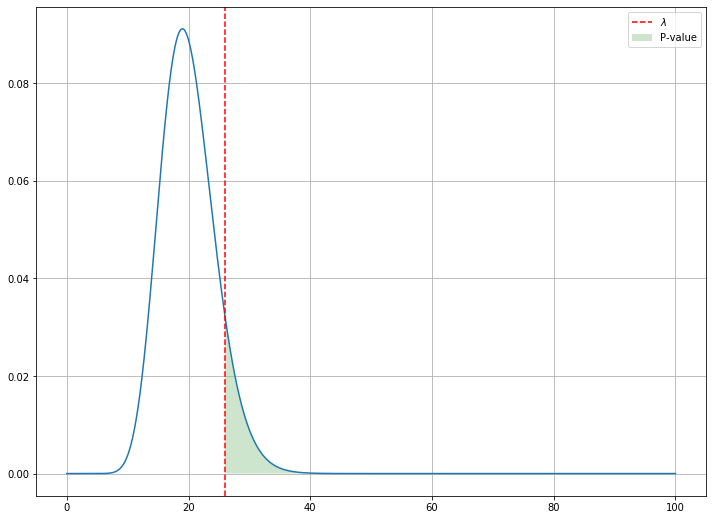

In [19]:
x = np.linspace(0, 100, 1000)
f = gamma(20)
plt.plot(x, f.pdf(x))

a = 26

print("P-value =", 1 - f.cdf(a))
print("Z =", toZ(1 - f.cdf(a)))
xs = np.linspace(a, x.max(), 1000)
    
plt.axvline(a, c='r', ls='--', label="$\lambda$")
plt.fill(np.concatenate([xs, xs[::-1]]),
     np.concatenate([f.pdf(xs), np.zeros(xs.shape)]),
     alpha=.2, fc='g', label="P-value")
plt.grid()
plt.legend()
plt.show()

# Критерий согласия $\chi^2$

Предположим, что наши данные распределены по некому известному закону $P(x)$. Это будет нашей нулевой простой гипотезой. Противоположной гипотезой будет выступать предположение, что данные получены из любого другого распределения.

Рассмотрим случайную величину $x$, которая может принимать $K$ значений: $x_1, \ldots, x_K$. Для непрерывной случайной величины мы можем ввести интервалы, попадание в которые мы будем считать исходом, т.е. перейдем от непрерывной величины к дискретной.

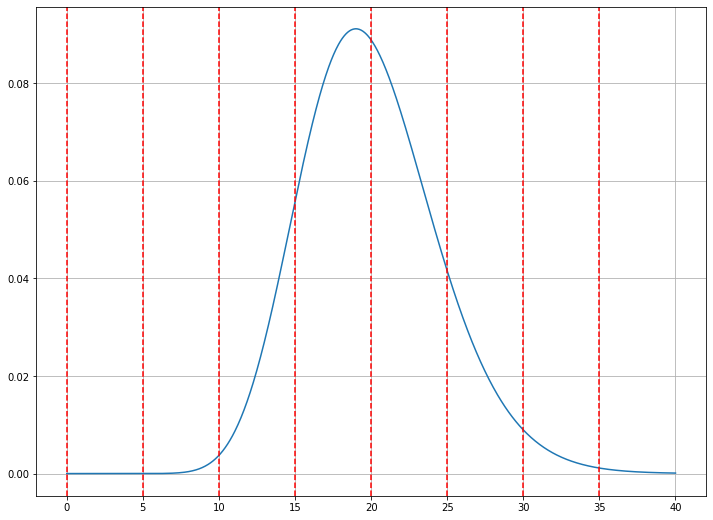

In [13]:
x = np.linspace(0, 40, 1000)
f = gamma(20)
plt.plot(x, f.pdf(x));
for xv in np.arange(0, x.max(), 5):
    plt.axvline(xv, ls='--', c='r')
plt.grid()

Введем вектор $\vec{\theta}$, компоненты которого $\theta_k = 1$ если $x = x_k$ и $\theta_k = 0$ во всех остальных случаях. 

Например, если $x$ результат броска игральной кости, то если выпало 2

$$
\vec{\theta}(x = 2) = (0, 1, 0, 0, 0, 0)^T 
$$

Таким образом $\vec{\theta}$ является многомерной случайной величиной (обобщение испытания Бернули), для которой имеет место

$$
\sum_k \theta_k = 1
$$

Все это мы записали для одного исхода. В общем случае множества исходов, мы можем ввести матрицу $\mathbf{\Theta}$, записывая $\vec{\theta}$ для исходов в столбцы этой матрицы.

$$
\mathbf{\Theta} = (\vec{\theta}_1, \ldots, \vec{\theta}_N)
$$

Полную частоту появления какого-то значения случайной величины мы можем получить просуммировав по всем исходам

$$
r_k = \sum_n \theta_{kn}
$$

Мы только что изобрели гистограмму. Если внимательно смотреть на $\vec{r}$, то можно понять что мы фактически получили величину распределенную по полиномиальному закону

$$
P(\vec{r}) = \frac{N!}{r_1!r_2!\ldots r_K!} p_1^{r_1} p_2^{r_2} \ldots p_K^{r_K}
\\
\sum_k r_k = N
\\
P(x = x_k) = p_k
$$

Если исходов довольно много, то $\vec{r}$ является суммой довольно большого числа случайных величин, что по идее указывает на то, что можно воспользоваться центральной предельной теоремой (в случае $Np_k > 4$), что дает 

$$
r_k \sim \mathcal{N}(r_k| \mu = Np_k, \sigma^2 = Np_k)
$$

А значит, величина в рамках гипотезы $H_0$

$$
z_k = \frac{r_k - N p_k}{\sqrt{N p_k}}
$$

распределена по $\mathcal{N}(z_k | 0, 1)$

Отсюда сумма квадратов $z_k$

$$
\chi^2_\nu = \sum_k z_k^2 = \sum_k \frac{(r_k - N p_k)^2}{N p_k}
$$

распределена как хи-квадрат с неким число степеней свободы.

Число степеней свободы мы определяем как 

$$
\nu = K - 1 - t
$$

где $t$ - это число параметров, которые будут оцениваться на основе представленных данных. (-1) возникает из-за того, что у нас есть уже одно ограничение, связывающее наши данные $\sum_k r_k = N$. Оценки параметров приведут к тому же самому - будут связывать наши данные.

# Пример 

Приведем классический пример использования критерия согласия $\chi^2$.

У нас есть данные за 20 лет о числе погибших офицеров в результате гибели под ними коня. Данные основаны на ежегодных отчетах десяти армейский корпусов.


| Число погибших офицеров, $x$  | Число донесений $r_x$ с количеством погибших офицеров $x$ |
| ----------------------------- | --------------------------------------------------------- |
| 0          | 109                   |
| 1          | 65                   |
| 2          | 22                   |
| 3          | 3                   |
| 4          | 1 |
| 5          | 0 |
| 6          | 0 |
| Всего          | 200                  |

Предположим, что наши данные распределены по Пуассону со средним, которое мы оценим из наших данных. Это и будет нашей гипотезой $H_0$.

In [30]:
r = np.array([109, 65, 22, 3, 1, 0, 0])
x = np.array([0, 1, 2, 3, 4, 5, 6])
N = r.sum()

# Посчитаем количество смертей
corpses = (r * x).sum()

print("Corpses = ", corpses)

# Наилучшая оценка среднего из них по методу максимального правдоподобия
m = corpses / N

print("Mean = ", m)

Corpses =  122
Mean =  0.61


In [31]:
from scipy.stats import poisson

pdf = poisson(m)

# Посчитаем наиболее вероятное количество смертей исходя из этой оценки - N p_i
# Так выводить нельзя, но сейчас это удобно ;)
# Слева оценка из гипотезы, справа то, что получено из наблюдений(отчеты)
for xv in x:
    print("[%3d] = %7.3f      Obs[%3d] = %7.3f" % (xv, N * pdf.pmf(xv), xv, r[xv]))

[  0] = 108.670      Obs[  0] = 109.000
[  1] =  66.289      Obs[  1] =  65.000
[  2] =  20.218      Obs[  2] =  22.000
[  3] =   4.111      Obs[  3] =   3.000
[  4] =   0.627      Obs[  4] =   1.000
[  5] =   0.076      Obs[  5] =   0.000
[  6] =   0.008      Obs[  6] =   0.000


In [32]:
# Считаем хи-квадрат

Npi = N * pdf.pmf(x)

u = ((r - Npi)**2 / Npi).sum()

print("U = ", u)

U =  0.7896272973000209


Хорошо, мы посчитали $u$, но что нам делать дальше? Если мы считаем нашу гипотезу верной, то в рамках этой гипотезы данная величина будет распределена как $\chi^2$ c $(7 - 1 - 1 = 5)$ степенью свободы. 

ChiMax = 15.08627246938899
P-value = 0.9776902240742161
Z = 0.02796480202700276


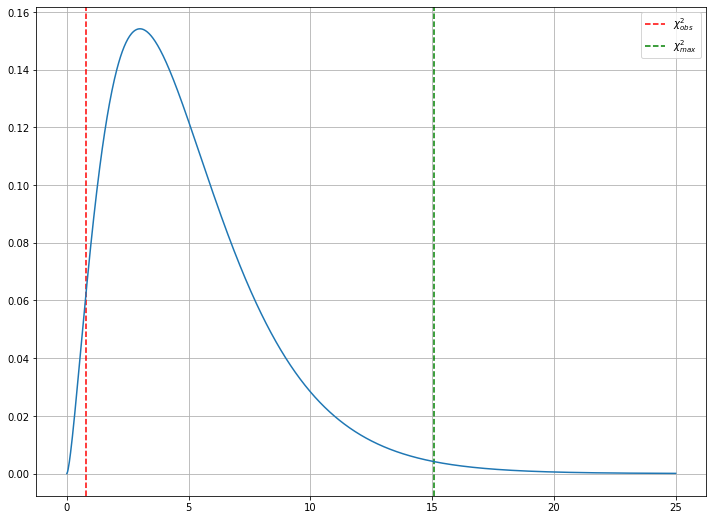

In [68]:
from scipy.stats import chi2

alpha = 0.01
xvs = np.linspace(0, 25, 1000)

# Определяем максимальное значение для хи-квадрата для заданной вероятности
df = 7 - 1 - 1
chiMax = chi2.ppf(1 - alpha, df)
print("ChiMax =", chiMax)
print("P-value =", 1 - chi2.cdf(u, df))
print("Z =", toZ(1 - chi2.cdf(u, df)))

plt.axvline(u, c='r', ls='--', label="$\chi_{obs}^2$")
plt.axvline(chiMax, c='g', ls='--', label="$\chi_{max}^2$")
plt.plot(xvs, chi2.pdf(xvs, df));
plt.grid()
plt.legend()
plt.show()

Выберем уровень значимости $\alpha = 0.01$.

Здесь мы нашли, что вероятность получения $u$ в интервале $[0, 15.08]$ равна 99%. Наше значение находится в этом интервале, а значит отвергнуть данную гипотезу мы не можем. Тут стоит отметить, что это не означает верность нашей гипотезы, мы просто от нее отказаться не можем. Вместе с ней мы можем предлагать новые гипотезы.

Если бы мы получили значение выше этого, то могли сказать, что наша гипотеза не верна и ошиблись бы при этом в худщем случае в 1% случаев.

## Замечание

Данный критерий плохо работает для редких событий. Для этого их объединяют в одно значение.

| Число погибших офицеров, $x$  | Число донесений $r_x$ с количеством погибших офицеров $x$ |
| ----------------------------- | --------------------------------------------------------- |
| 0          | 109                   |
| 1          | 65                   |
| 2          | 22                   |
| >=3          | 4                   |
| Всего          | 200                  |

U =  0.3235235766087142
ChiMax = 9.21034037197618
P-value = 0.8506438137125903
Z = 0.18829702964083475


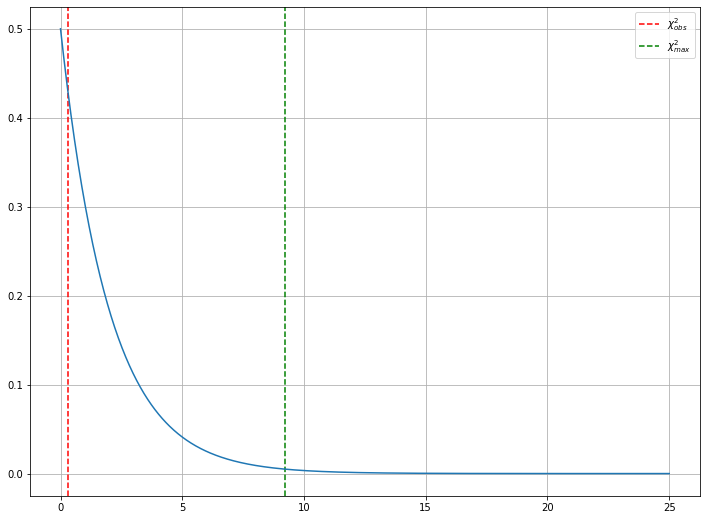

In [53]:
r = np.array([109, 65, 22, 4])
x = np.array([0, 1, 2, 3])
N = r.sum()

# Мы его уже посчитали
m =  0.61

pdf = poisson(m)
Npi = N * pdf.pmf(x)
# Здесь последнее число неправильно написано, поэтому 
# считаем отдельно
Npi[-1] = N * (1 - pdf.cdf(x[-2]))

u = ((r - Npi)**2 / Npi).sum()

print("U = ", u)

from scipy.stats import chi2

alpha = 0.01
xvs = np.linspace(0, 25, 1000)

# Определяем максимальное значение для хи-квадрата для заданной вероятности
# df = 4 - 1 - 1 = 2
df = 4 - 1 - 1
chiMax = chi2.ppf(1 - alpha, df)
print("ChiMax =", chiMax)
print("P-value =", 1 - chi2.cdf(u, df))
print("Z =", toZ(1 - chi2.cdf(u, df)))

plt.axvline(u, c='r', ls='--', label="$\chi_{obs}^2$")
plt.axvline(chiMax, c='g', ls='--', label="$\chi_{max}^2$")
plt.plot(xvs, chi2.pdf(xvs, df));
plt.grid()
plt.legend()
plt.show()

## Мнемоническое правило

Иногда можно пользоваться мнемоническим правилом определения точности на глаз. Можно увидеть, что если мы перейдем к распределения $\frac{\chi^2_{\nu}}{\nu}$, то можно увидеть, что в среднем вероятность получить значения этой величины больше 1 будет около 40% - 45%. При одной степени свободы - это практически совпадает с вероятностью $1\sigma$.

  1 => 0.32
  2 => 0.37
  3 => 0.39
  4 => 0.41
  5 => 0.42
  6 => 0.42
  7 => 0.43
  8 => 0.43
  9 => 0.44
 10 => 0.44
 15 => 0.45


(0, 0.1)

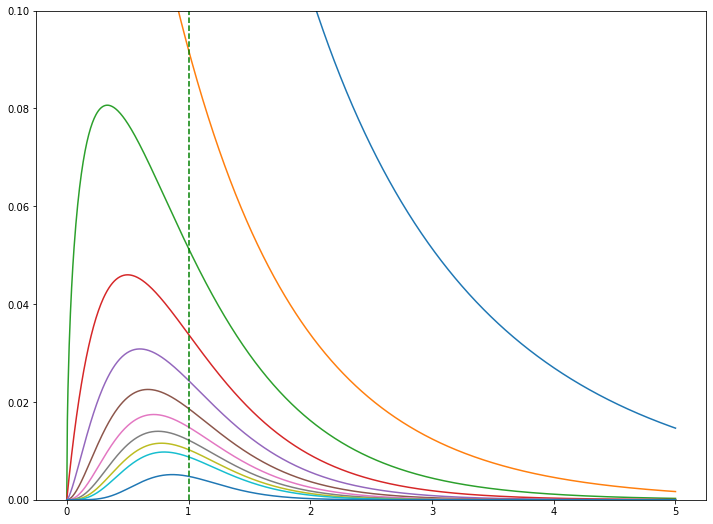

In [109]:
from scipy.stats import chi2

x = np.linspace(0, 5, 1000)

for df in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15]:
    y = chi2.pdf(x*df, df) / df
    print("%3d" % df, "=>", "%.2f" % (1 - chi2.cdf(df, df)))
    plt.plot(x, y)
    
plt.axvline(1, ls="--", c='g')
plt.ylim(0, 0.1)

# Правдоподобие в физике высоких энергий

В прошлых лекциях мы установили, что для $N$ независимых наблюдений $x_1, \ldots, x_N$, мы можем записать функцию правдоподобия

$$
L(\vec{\theta}|\mathbf{X}) = \prod_{n=1}^{N} f(x_n | \vec{\theta})
$$

На практике, в наших экспериментах число $N$ является также случайной величиной, а следовательно - нам нужно модифицировать функцию правдоподобия, чтобы учесть этот факт

$$
L(\vec{\theta}|\mathbf{X}) = f(N|\vec{\theta}) \prod_{n=1}^{N} f(x_n | \vec{\theta})
$$

Чаще всего $f(N|\vec{\theta})$ - это распределение Пуассона, что в итоге нам дает

$$
L(\vec{\theta}|\mathbf{X}) = \frac{\lambda^N}{N!} e^{-\lambda} \prod_{n=1}^{N} f(x_n | \vec{\theta})
$$

Обычно, мы будем выделять фоновые события (background) и сигнальные события (signal). Для каждого из них будет свое распределение $f_b$ и $f_s$. Полное распределение $f$ является смесью этих распределений

$$
L(\vec{\theta}|\mathbf{X}) = \frac{\lambda^N}{N!} e^{-\lambda(\vec{\theta})} 
\prod_{n=1}^{N} \left(
c_s f_s(x_n | \vec{\theta}) + c_b f_b(x_n | \vec{\theta}) 
\right)
$$

где $c_s + c_b = 1$, $s$ и $b$ - среднее ожидаемое количество сигнальных и фоновых событий. Значения $c_s$ и $c_s$ довольно легко найти - это просто доля соответствующих событий к полному числу предполагаемых событий (вероятность того, что это фон или сигнал по сути)

$$
c_s = \frac{s}{s + b} 
\\
c_b = \frac{b}{s + b}
\\
\lambda = s + b
$$

В итоге

$$
L(\vec{\theta}|\mathbf{X}) 
= 
\frac{ 1 }{ N!} 
e^{-(s + b)} 
\prod_{n=1}^{N} \left(
s f_s(x_n | \vec{\theta}) + b f_b(x_n | \vec{\theta}) 
\right)
$$

или

$$
\mathcal{L} = \ln L = -(s + b) - N! + \sum_n \ln\left(
s f_s(x_n | \vec{\theta}) + b f_b(x_n | \vec{\theta}) 
\right)
$$

В самом общем случае, $s$ и $b$ - это тоже функции вектора параметров $\vec{\theta}$.

Часто вводят $s = \mu s_0$, где $\mu$ - это сила сигнала (0 - нет сигнала, 1 - есть), а $s_0$ - предсказываемое теорией значение.

## Пример

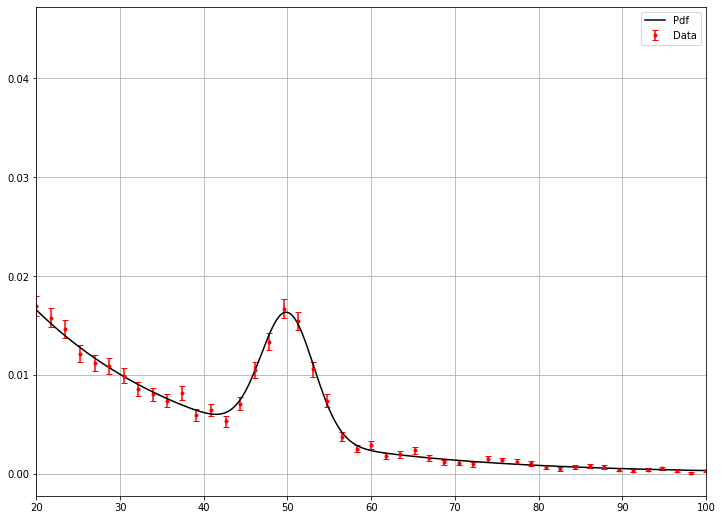

In [55]:
from scipy.stats import norm, expon, poisson

ps = 0.1
pb = 1 - ps
lam = 10000
N = poisson.rvs(lam)

m_s = 50
s2_s = 10

lam_b = 0.05

weights = [ps, pb]
rds = [norm(m_s, np.sqrt(s2_s)), expon(scale=1/lam_b)]
mixture_idx = np.random.choice(len(weights), size=N, replace=True, p=weights)
samples = np.fromiter( (rds[i].rvs() for i in mixture_idx), float)

h, edges = np.histogram(samples, bins=100)
herr = np.sqrt(h)
hx = (edges[1:] + edges[:-1]) * 0.5

herr = herr / h.sum() / (edges[1] - edges[0])
h = h / h.sum() / (edges[1] - edges[0])

#plt.hist(samples, density=True, bins=100)
#plt.plot(hx, h, "ro")
plt.errorbar(hx, h, yerr=herr, fmt=".", c='r', capsize=3, label="Data")

x = np.linspace(samples.min(), samples.max(), 1000)
y = ps * rds[0].pdf(x) + pb * rds[1].pdf(x)
plt.plot(x, y, "k-", label="Pdf");
plt.xlim(20, 100)
plt.grid()
plt.legend()
plt.show()

Здесь фоновые события описывается экспоненциальной функцией

$$
f_b(x|\lambda_b) = \lambda_b e^{-\lambda_b}
$$

А сигнальные экспонентой

$$
f_s(x|\mu_s, \sigma^2_s) = \frac{1}{\sqrt{2\pi \sigma^2_s}} e^{-\frac{(x-\mu_s)^2}{2\sigma_s^2}}
$$

## Гистрограммы

Иногда наши данные представлены исключительно в виде гистограммы. Что нам делать в этом случае?

Мы установили, что гистограммы подчиняются мультиномиальному закону, где каждый бин $r_k$ - это компонента вектора наблюдения

$$
P(\vec{r}) = \frac{N!}{x_1!x_2!\ldots x_K!} p_1^{x_1} p_2^{x_2} \ldots p_K^{x_K}
$$

При этом несложно показать, что, как и биномиальное, мультиномиальное распределение сходится к распределению Пуассона в каждом бине.

Далее, будем обозначать $\mathcal{P}(x|\lambda(\vec{\theta}))$ как распределение Пуассона. В итоге правдоподобие для гистограммы примет вид

$$
L = \prod_k \mathcal{P}(r_k | \lambda_k(\vec{\theta}))
\\
\ln L = - \sum_k \ln r_k! - \sum_k \lambda_k(\vec{\theta}) + \sum_k r_k \ln \lambda_k(\vec{\theta})
$$

При этом мы нередко можем заменить $\lambda_k$ на непрерывную функцию $\lambda(x, \vec{\theta})$ по $x_k$ (центрам бинов) или комбинацией гистограмм, полученных как пример на разных Монте-Карло генераторах.


При достаточно большом числе наблюдений, мы ранее получили, что имеет место 

$$
\chi^2 = \sum_k \frac{(r_k - \lambda_k(\vec{\theta}))^2}{\lambda_k(\vec{\theta})}
$$

Таким образом фит в случае гистограмм сводится к минимизации критерия $\chi^2$

# Критерий Неймана-Пирсона

В случае простых гипотез $H_0$ и $H_1$, как в примере выше, существует всюду оптимальный односторонний критерий

$$
\lambda(\mathbf{X}) = \frac{L(H_1 | \mathbf{X})}{L(H_0 | \mathbf{X})} > k_{\alpha}
$$

где $L$ - это функция правдоподобия для соответсвующей гипотезы, $k_{\alpha}$ - специальная константа, которая определяется исходя из уровня значимости.

Если $\lambda(\mathbf{X}) > k_{\alpha}$, то принимают гипотезу $H_1$, если $\lambda(\mathbf{X}) \le k_{\alpha}$ - $H_0$.

В самом общем случае не всегда возможно построить функцию правдоподобия, в этом случае могут помочь методы машинного обучения, которые позволяют аппроксимировать это отношение.

Также не всегда возможно найти распределение $\lambda(\mathbf{X})$ в явном виде. В этом случае, данное распределение можно получить с помощью Монте-Карло генераторов. То есть мы банально генерируем как можно больше вариантов исхода, для которых смотрим значение критерия.

# Profile Likehood

Одним из интересных подходов к учету вспомогателных параметров является - profile likehood. В этом подходе фиксируются интересуемыми параметры, а остальные параметры оцениваются исходя из этого методом максимального правдоподобия

$$
L(\vec{\theta}) = \max_{\vec{\omega}} L(\vec{\theta}, \vec{\omega}) = L(\vec{\theta}, \hat{\vec{\omega}})
$$

Здесь $\hat{\vec{\omega}}$ - это оценка по методу максимального правдоподобия при заданых каких-то значениях $\vec{\theta}$.

Рассмотрим для примера такую функцию правдоподобия, в которой $\sigma^2$ является вспомогательным параметром

$$
L = \frac{1}{(2\pi\sigma^2)^{N/2}} \exp \left(
-\frac{1}{2\sigma^2} \sum_n (x_n - \mu)^2
\right)
\\
\ln L = - \frac{N}{2} \ln \sigma^2 - \frac{1}{2\sigma^2} \sum_n (x_n - \mu)^2
$$

Откуда 

$$
\hat{\sigma}^2(\mu) = \frac{1}{N} \sum_n (x_n - \mu)^2 
$$


# Теорема Вилка (Wilk's theorem)

Пусть у нас есть некая функция распределения $f(\mathbf{X} | \vec{\theta})$ (функция правдоподобия), котороая зависит от $\vec{\theta}$ параметров.

Пусть у нас есть гипотеза $H_0$, такая что $\vec{\theta} \in \Theta_0$, где $\Theta_0$ - это некая область в пространстве возможных значений набора параметров (в оригинальной статье, Вилк просто фиксировал некоторые параметры, задавая для них значения).

Пусть у нас есть альтернативная гипотеза, такая что $\vec{\theta} \in \Omega$, где $\Omega$ - это пространство всех возможных значений параметра (ни один параметр не зафиксирован).


Это нам дает критерий


$$
\lambda = -2 \ln \frac{ \max\limits_{\vec{\theta} \in \Theta_0} f(\mathbf{X}, \vec{\theta}) }
{ \max\limits_{\vec{\theta} \in \Omega} f(\mathbf{X}, \vec{\theta}) }
$$

Здесь видно, что гипотеза $H_0$ включена в общее пространство значений $\Omega$.

> Если $\nu$ - размерность пространства $\Omega$, а $r$ - размерность $\Theta_0$, то величина $\lambda$ в предположении правдивости гипотезы $H_0$ распределена асимптотически как $\chi^2_{\nu - r}$.

Это очень удобно использовать с профилем функции правдоподобия

$$
\lambda(\vec{\theta}) = -2 \ln \frac{
    L(\vec{\theta}, \hat{\vec{\omega}} | \mathbf{X})
}{
    L(\hat{\vec{\theta}}, \hat{\hat{\vec{\omega}}} | \mathbf{X})
}
$$

где $\hat{\vec{\omega}}$ оценка при заданном значении $\vec{\theta}$, $\hat{\hat{\vec{\omega}}}$ - оценка полученная вместе с оценкой $\hat{\vec{\theta}}$.

# Пример применения критерия Неймана-Пирсона

Предположим измерается некая величина, например, интенсивность пучка. Мы хотим проверить, изменится ли эта интенсивность после внесения модификаций в апаратуру. При этом погрешность измерения пусть будет $\sigma$. Тогда 
* $H_0$ - $\mathcal{N}(\mu_0, \sigma^2)$, мы предполагаем, что интенсивность не изменилась и равна $\mu_0$.
* $H_1$ - $\mathcal{N}(\mu_1, \sigma^2)$, мы предполагаем, что она изменилась и стала $\mu_1 > \mu_0$ 

При этом, после модификации мы провели $N$ измерений. Откуда

$$
\lambda = \frac{\exp\left(-\frac{1}{2\sigma^2} \sum_n (x_n - \mu_1)^2 \right)}{\exp\left(-\frac{1}{2\sigma^2} \sum_n (x_n - \mu_0)^2 \right)}
$$

Здесь удобно взять логарифм

$$
\lambda = \frac{\exp\left(-\frac{1}{2\sigma^2} \sum_n (x_n - \mu_1)^2 \right)}{\exp\left(-\frac{1}{2\sigma^2} \sum_n (x_n - \mu_0)^2 \right)}
\\
\sigma^2 \ln \lambda =  N (\mu_1 - \mu_0) \, \overline{x}  + \frac{N}{2}(\mu_0^2 - \mu_1^2)
\\
\sqrt{N} \frac{\sigma^2 \ln \lambda - \frac{N}{2}(\mu_0^2 - \mu_1^2)}{\sigma N (\mu_1 - \mu_0)} - \sqrt{N} \frac{\mu_0}{\sigma} = \sqrt{N} \frac{\overline{x} - \mu_0}{\sigma}
$$

Для простоты, введем обозначение

$$
z = \sqrt{N} \frac{\overline{x} - \mu_0}{\sigma}
$$

Выражение справа, распределено как $\mathcal{N}(z|0, 1)$ если верна $H_0$, и $\mathcal{N}\left(z| \frac{\sqrt{N}}{\sigma}(\mu_1 - \mu_0), 1\right)$, если верна $H_1$. 


Выражение слева станет нашим критерием.


В предположении $H_0$ это означает, что мы можем отвергнуть эту гипотезу, если $z > k_\alpha$, где $k_\alpha$ определяется уровнем значимости $\alpha$. Пусть это будет 5%.

In [59]:
from scipy.stats import norm

a = 0.05

ka = norm.ppf(1 - a)
print("ka =", ka)

ka = 1.6448536269514722


Для данного уровня значимости мы получили $k_\alpha = 1.65$, что дает область $\{R: z > k_\alpha\}$. Тут нужно понимать, что эта область должна быть спроецирована на пространство возможных значений $\mathbf{X}$.

Чтобы найти мощность, нам нужно проинтегрировать распределение критерия в рамках гипотезы $H_1$ по этой области.

$$
1 - \beta = \int_{k_\alpha}^\infty \mathcal{N}\left(z| \frac{\sqrt{N}}{\sigma}(\mu_1 - \mu_0), 1\right) \, dz 
\\
\beta = \Phi\left(k_\alpha - \frac{\sqrt{N}}{\sigma} (\mu_1 - \mu_0) \right)
\\
\Phi(x) = \int_{-\infty}^x \mathcal{N}(x|0, 1) \, dx
$$

Здесь мы видим, что с ростом числа экспериментов, либо с увеличением разницы $\mu_1$ и $\mu_0$, вероятность ошибки второго рода будет уменьшаться. Это свойство называется состоятельность, то есть с ростом числа экспериментов мощность будет стремится к 1.

Beta =  0.004342367908860843


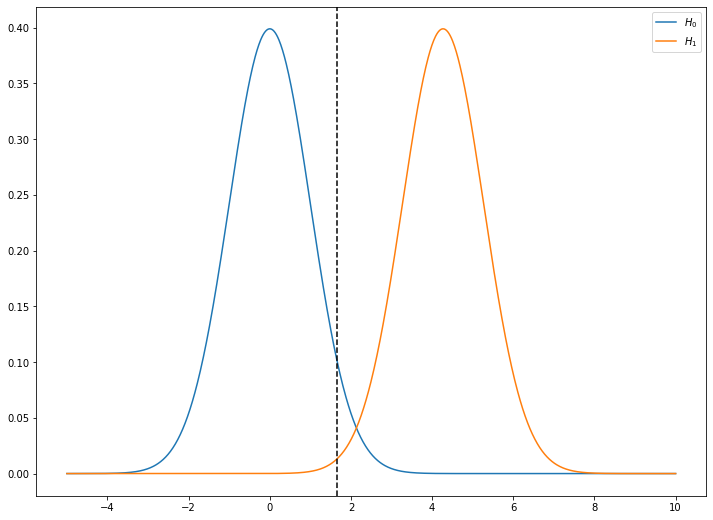

In [60]:
from scipy.stats import norm

N = 1000
s2 = 4
m0 = 2
m1 = 2.27

pdf0 = norm(m0, np.sqrt(s2))
pdf1 = norm(m1, np.sqrt(s2))

print("Beta = ", norm.cdf( ka - np.sqrt(N/s2)*(m1-m0) ) )

x = np.linspace(-5, 10, 1000)
plt.plot(x, norm(0).pdf(x), label="$H_0$")
plt.plot(x, norm( np.sqrt(N/s2)*(m1-m0) ).pdf(x), label="$H_1$")
plt.axvline(ka, c='k', ls="--")
plt.legend()
plt.show()

H0 True =  1.0
H0 False (alpha) =  0.0
H1 True =  0.0
H1 False (beta) =  1.0


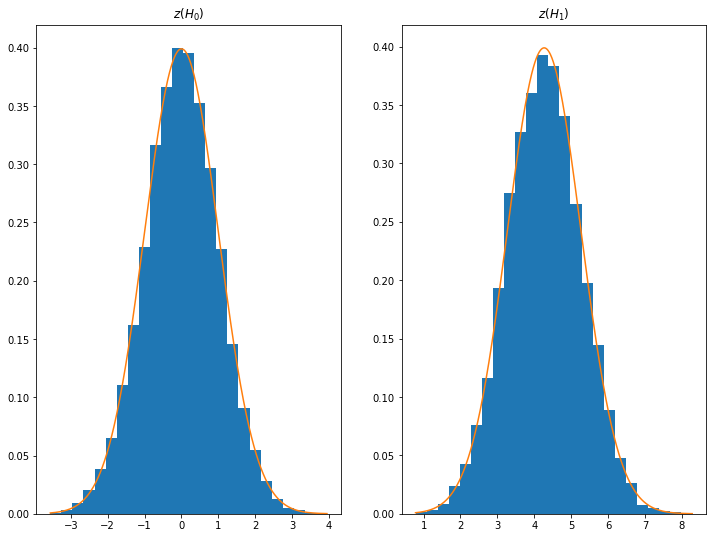

In [54]:
# Теперь проверим, что мы вывели все распределения правильно 
# Построим распределения критерия исходя из гипотезы с помощью генератора случайных чисел

N = 1000
T = 10000

t0 = []
t1 = []

# Угадали H0 правильно
h0_true = 0
# Сказали, что H1, хотя на самом деле H0
h0_false = 0

# Угадали H1 правильно
h1_true = 0
# Сказали, что H0, хотя на самом деле H1
h1_false = 0


for _ in range(T):
    samples0 = pdf0.rvs(size=N)
    samples1 = pdf1.rvs(size=N)
    
    z0 = np.sqrt(N) * (samples0.mean() - m0) / np.sqrt(s2)
    t0.append(z0)
    if z0 > ka:
        h0_false += 1
    else:
        h0_true += 1
    
    z1 = np.sqrt(N) * (samples1.mean() - m0) / np.sqrt(s2)
    t1.append(z1)
    if z1 <= ka:
        h1_false += 1
    else:
        h1_true += 1
    
print("H0 True = ", h0_true / T)
print("H0 False (alpha) = ", h0_false / T)  

print("H1 True = ", h1_true / T)
print("H1 False (beta) = ", h1_false / T) 

plt.subplot(121)
plt.title("$z(H_0)$")
plt.hist(t0, bins=25, density=True)
x = np.linspace(np.min(t0), np.max(t0), 1000)
plt.plot(x, norm.pdf(x))

plt.subplot(122)
plt.title("$z(H_1)$")
plt.hist(t1, bins=25, density=True)
x = np.linspace(np.min(t1), np.max(t1), 1000)
plt.plot(x, norm( np.sqrt(N/s2)*(m1-m0) ).pdf(x))

plt.show()

# Фитирование

Пусть у нас есть некая функция $g(x) = ax + b$, при измерении вносится ошибка, распределенная по известному нормальному закону $\mathcal{N}(0, 1)$

$$
y = g(x) + \varepsilon
$$

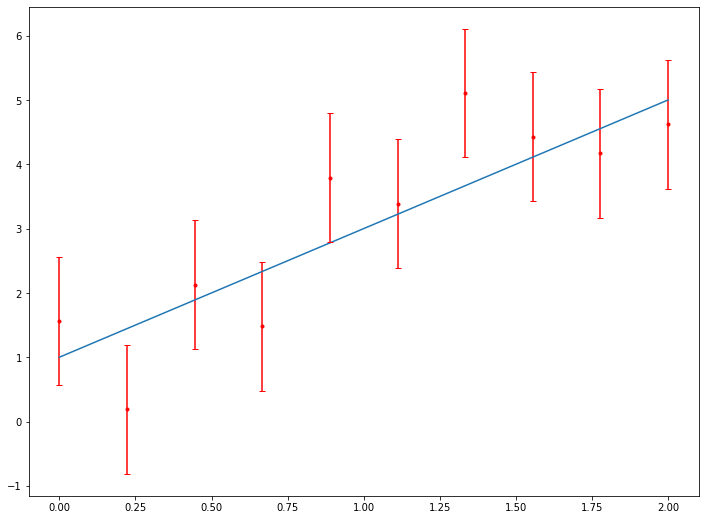

In [3]:
from scipy.stats import norm

a = 2
b = 1

x = np.linspace(0, 2, 10)
y = a * x + b
noise = norm.rvs(size=x.shape)
yn = y + noise

plt.plot(x, y)
plt.errorbar(x, yn, yerr=1, fmt=".", c='r', capsize=3, label="Data")
plt.show()

То есть наши данные в конкретной точке подчиняются $\mathcal{N}(x | g(x), 1)$.

Тогда мы можем записать правдоподобие

$$
y = x + \varepsilon
\\
\varepsilon \sim \mathcal{N}(x | 0, 1)
\\
L = \prod_n \mathcal{N} (y_n | g(x_n), 1) = \frac{1}{(2\pi\sigma^2)^{N/2}} \exp\left(
-\frac{1}{2} \sum_n \left(\frac{y_n - g(x_n)}{\sigma} \right)^2
\right)
\\
\mathcal{L} = - \frac{N}{2} \ln (2\pi\sigma^2) - \frac{1}{2} \sum_n \left(\frac{y_n - a x_n - b}{\sigma} \right)^2
\\
\hat{a} = \frac{ N \sum_n x_n y_n - \left(\sum_n x_n \right) \left(\sum_n y_n\right) } {N \sum x_n^2 - \left(\sum_n x_n\right)^2}
\\
\hat{b}  = \frac{ \left(\sum_n x_n^2\right)  \left(\sum_n y_n\right) - \left(\sum_n x_n\right) \left(\sum_n x_n y_n\right) }{N \sum x_n^2  - \left(\sum_n x_n\right)^2}
$$

Последнее слагаемое в $\mathcal{L}$ с $\hat{a}$ и $\hat{b}$ ведет себя как $\chi_r^2$, где $r = N - k$, $k$ - число параметров, которые будем оценивать из данных (у нас их 2). По нему можно оценить, можно ли отвергнуть гипотезу о том, что данные сгенерированы из распределения с параметрами $\hat{a}$ и $\hat{b}$.

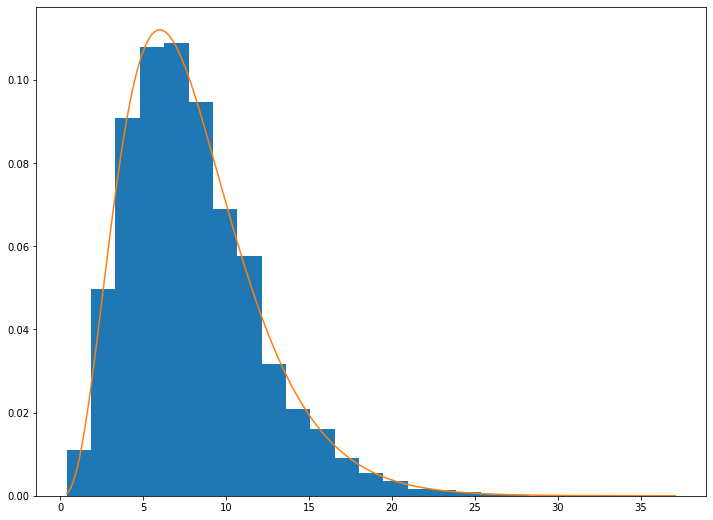

In [61]:
from scipy.stats import norm, chi2

# Оценка a и b с помощью данных
def calc(y, x):
    N = y.shape[0]
    
    s_xy = (x * y).sum()
    s_x2 = (x * x).sum()
    s_x = x.sum()
    s_y = y.sum()
    
    bottom = N * s_x2 - (s_x)**2
    
    return (N * s_xy - s_x * s_y) / bottom, (s_x2 * s_y - s_x * s_xy) / bottom

a = 2
b = 1

x = np.linspace(0, 2, 10)
y = a * x + b

t = []
for _ in range(10000):
    # Генерируем шум и добавляем его
    noise = norm.rvs(size=x.shape)
    yn = y + noise
    
    ha, hb = calc(yn, x)
    
    # расчитываем последнее слагаемое
    L = ((yn - ha * x - hb )**2).sum()
    t.append(L)

plt.hist(t, bins=25, density=True)
cx = np.linspace(np.min(t), np.max(t), 1000)
plt.plot(cx, chi2.pdf(cx, x.shape[0] - 2))
plt.show()

Рассмотрим, как ведет себя $\mathcal{L}(a, b) - \mathcal{L}(\hat{a}, \hat{b})$, если зафиксировать $b$

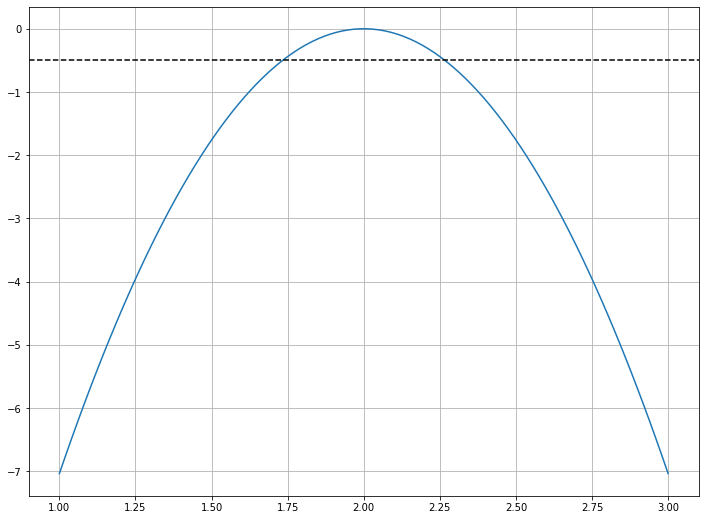

In [64]:
a = 2
b = 1

x = np.linspace(0, 2, 10)
y = a * x + b
noise = norm.rvs(size=x.shape)
yn = y + noise

def lnL(a, b, y, x):
    return -x.shape[0]/2 * np.sqrt(2 * np.pi) -0.5 * ( (y - a * x - b)**2 ).sum()

h_a, h_b = calc(y, x)

v = []
vas = np.linspace(h_a - 1.0, h_a + 1.0, 100)
for va in vas:
    v.append(lnL(va, h_b, y, x) - lnL(h_a, h_b, y, x))
    
plt.plot(vas, v)
plt.axhline(-0.5, ls="--", c='k')
plt.grid()

Если бы нам было известно $b$, то мы могли бы по уровню $-\frac{1}{2}$ провести доверительный интервал для $1\sigma$, но так как нам эта величина не знакома, то мы должны рассматривать их одновременно. Это будет соответствовать "куполу" многомерного нормального распределения, для него уровень $1\sigma$ будет принимать другое значение.

Интересно то, что даже если бы это не была бы параболла (например что-то ассимитричное), то мы могли бы найти такое преобразование, которое свело бы его к параболле (это нельзя сделать, если максимумов несколько). После преобразования найти уровен и перейти обратно. Окажется, что это эквивалентно нахождению значений параметра на все том же уровне $-\frac{1}{2}$, но это даст ассимитричный доверительный интервал относительно максимума.

Это эквивалентно тому, чтобы мы рассматривали совместное распределение двух независимых случайных величин

$$
f(a', b') = \frac{1}{2\pi \sigma_a \sigma_b} e^{-\frac{(a'-\hat{a})^2}{2\sigma_a^2} - \frac{(b' - \hat{b})^2}{2\sigma_b^2}}
\\
\mathcal{L}(a', b') = -\ln(2\pi\sigma_a \sigma_b) -\frac{(a' - \hat{a})^2}{2\sigma_a^2} - \frac{(b' - \hat{b})^2}{2\sigma_b^2}
$$

Что дает $-2 ( \mathcal{L} - \mathcal{L}(\hat{a}, \hat{b}) ) \sim \chi^2_2$. 


Отсюда можно найти границу для $\mathcal{L}(a, b) - \mathcal{L}(\hat{a}, \hat{b})$ для которой будет соответствующий уровень $\alpha$

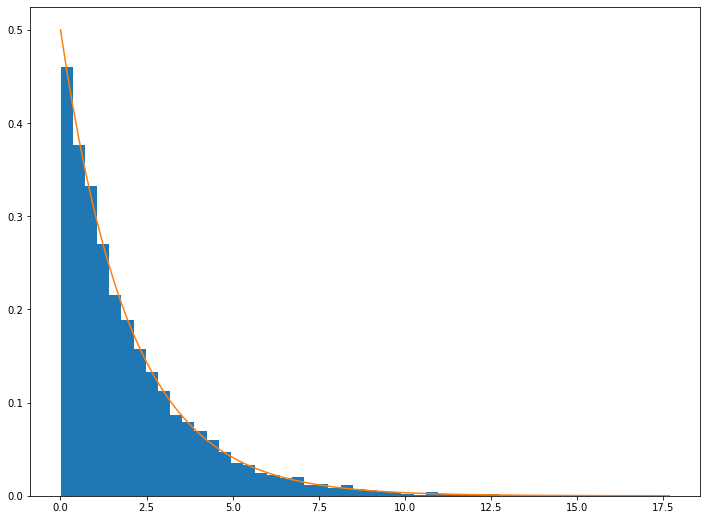

In [6]:
# Проверим, что у нас и правда распределение \chi_2^2

a = 2
b = 1

x = np.linspace(0, 2, 10)
y = a * x + b

ac = (x*x).sum()
bc = x.shape[0]

t = []
for _ in range(10000):
    noise = norm.rvs(size=x.shape)
    yn = y + noise
    
    ha, hb = calc(yn, x)
    dL = -2*(lnL(a, b, yn, x) - lnL(ha, hb, yn, x))
    t.append(dL)
    
plt.hist(t, bins=50, density=True);
xv = np.linspace(np.min(t), np.max(t), 100)
plt.plot(xv, chi2.pdf(xv, 2))
plt.show()

Здесь мы видим, что наше предположение верно. Разница функций правдоподобия дает распределение $\chi^2_2$. А значит мы можем выделить критическую область с уровнем $\alpha$.

In [110]:
from scipy.stats import chi2, norm

for k in [1, 2, 3, 4, 5]:
    alpha = 1 - (norm.cdf(k) - norm.cdf(-k))
    print("%3d * sigma = " %k, chi2.ppf(1 - alpha, df=2))

  1 * sigma =  2.295748928898636
  2 * sigma =  6.180074306244173
  3 * sigma =  11.829158081900795
  4 * sigma =  19.333908611934685
  5 * sigma =  28.743702426548186


Конкретно в нашем случае, мы можем получить аналитический вид доверительной области.

$$
\frac{\partial^2 \mathcal{L}}{\partial a^2} = -\frac{\sum_n x_n^2}{\sigma^2}
\\
\frac{\partial^2 \mathcal{L}}{\partial b^2} = -\frac{N}{\sigma^2}
\\
\frac{\partial^2 \mathcal{L}}{\partial a  \, \partial b} = -\frac{\sum_n x_n}{\sigma^2}
\\
\tilde{\mathcal{L}} = \mathcal{L}(a,b) - \mathcal{L}(\hat{a}, \hat{b}) = - \frac{1}{2} \frac{\sum_n x_n^2}{\sigma^2} (a - \hat{a})^2 - \frac{1}{2} \frac{N}{\sigma^2} (b - \hat{b})^2 - \frac{1}{2} \frac{\sum_n x_n}{\sigma^2} (a - \hat{a})(b - \hat{b})
$$

Если приравнять это к константе, то мы из курса геометрии, должны здесь увидеть уравнение эллипса, но немного повернутого.

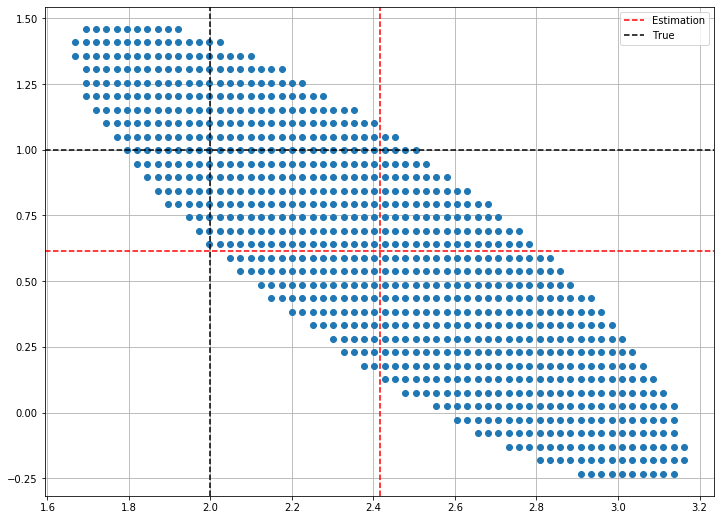

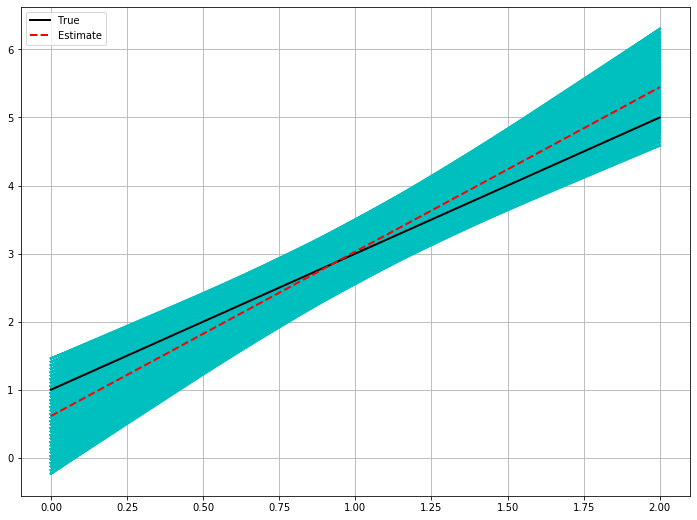

In [68]:
a = 2
b = 1

x = np.linspace(0, 2, 10)
y = a * x + b
noise = norm.rvs(size=x.shape)
yn = y + noise
ha, hb = calc(yn, x)
ka = -1.147874464449318

av = []
bv = []

for ac in np.linspace(ha - 1.0, ha + 1.0, 80):
    for bc in np.linspace(hb - 1, hb + 1, 40):
        dL = lnL(ac, bc, yn, x) - lnL(ha, hb, yn, x)

        if ka <= dL:
            av.append(ac)
            bv.append(bc)


plt.plot(av, bv, "o")
plt.axvline(ha, c="r", ls="--", label="Estimation")
plt.axhline(hb, c="r", ls="--")
plt.axvline(a, c="k", ls="--", label="True")
plt.axhline(b, c="k", ls="--")
plt.grid()
plt.legend()
plt.show()

x = np.linspace(0, 2, 10)
y = a * x + b

for ac, bc in zip(av, bv):
    plt.plot(x, ac*x + bc, "c-", lw=2)

plt.plot(x, y, "k-", lw=2, label="True")
plt.plot(x, ha * x + hb, "r--", lw=2, label="Estimate")
plt.grid()
plt.legend()
plt.show()

Таким образом в двухмерном случае уровень около $-1.148$ соответствует одномерному уровню $-\frac{1}{2}$ для одномерного случая с тем же уровнем значимости $\alpha$.

Этот уровень позволяет найти доверительную область. 

Здесь представлена доверительная область, которая накрывает истинное значение с вероятностью $1-\alpha$ в случае бесконечного числа экспериментов.

# Пример проверки гипотезы

Пусть у нас есть эксперимент, в котором мы считаем события (например [$pp\to H \to ZZ \to 4l$](https://arxiv.org/abs/1312.5353))). В данном эксперименте, мы насчитали $N = 25$ событий. Выделим две гипотезы
* $H_0$ - данные описываются только фоном
* $H_1$ - присутствует и фон, и сигнал

Мы получили $N$ событий. Тогда правдоподобие имеет вид

$$
L_0(s, b, N) = \frac{(s+b)^N}{N!} e^{-(s+b)}
$$

Обычно у нас уже есть оценка из теории на количество сигнальных и фоновых событий: $\tilde{s}$ и $\tilde{b}$. Альтернативно, у нас может быть задан фон, а вот сигнал нужно оценить исходя из данных. Пусть у нас есть сопутствующий эксперимент, в котором смогли измерить $\tilde{b} \pm \delta b$, нередко с помощью Монте-Карло генератора. 

Мы могли бы это дописать в виде нормального распределения, но мы можем вспомнить, что это эксперимент, в котором мы считаем события. Таким образом, в ходе этого виртуального эксперимента получили $Q$ событий с $\delta Q = \sqrt{Q}$ (считаем же). Оценку мы можем получить отмасштабировав наши данные с помощью коэффициента $k$, которое известно заранее.

$$
\tilde{b} \pm \delta b = \frac{Q}{k} \pm \frac{\sqrt{Q}}{k}
$$

У нас имеется оценка

$$
\tilde{b} \pm \delta b = 9.4 \pm 0.5
$$

Отсюда несложно восстановить значение $Q$ и $k$

In [33]:
b = 9.4
db = 0.5

k = b / (db * db)
Q = b * k

print("k =", k)
print("Q =", Q)

k = 37.6
Q = 353.44000000000005


Правдоподобие для этого вспомогательного эксперимента тогда

$$
L_b = \frac{(kb)^Q}{\Gamma(Q+1)} e^{-kb}
$$

или полное правдоподобие

$$
L(s, b) = L_0 L_b = \frac{(s+b)^N}{N!} e^{-(s+b)} \frac{(kb)^Q}{\Gamma(Q+1)} e^{-kb} 
= \frac{k^Q}{N! \Gamma(Q+1)} (s+b)^N b^Q e^{-s-(k+1)b}
$$

Здесь у нас два неизвестных параметра: $b$ и $s$. Нас интересует только $s$. Следовательно $b$ - это вспомогательный параметр.


Оценка по методу максимального правдоподобия довольно легко находится

$$
\frac{\partial L}{\partial b} \propto N (s+b)^{N-1} e^{-s-(k+1)b} b^Q - (k+1) (s+b)^N e^{-s-(k+1)b} b^Q + Q (s+b)^N e^{-s-(k+1)b} b^{Q-1}
\\
\frac{\partial L}{\partial s} \propto N (s+b)^{N-1} e^{-s-(k+1)b} - (s+b)^N e^{-s-(k+1)b}
$$

$$
\hat{b} = \frac{Q}{k} = \tilde{b}
\\
\hat{s} = N - \tilde{b}
$$


Теперь мы довольно легко можем построить критерий на основе профиля функции правдоподобия

$$
\lambda(s) = -2 \ln 
\frac{
    L(s, \hat{b})
}{
    L(\hat{s}, \hat{ \hat{b} })
} \sim \chi^2_1
\\
\hat{b} = \hat{\hat{b}} = \tilde{b}
\\
\hat{s} = N - \tilde{b}
$$

Рассмотрим случай только фона ($s=0$)

$$
\ln L(0, \tilde{b}) = Q \ln k - \ln N! - \ln  \Gamma(Q+1) + N \ln b + Q\ln b - (k+1)b 
\\
\ln L(N-\tilde{b}, \tilde{b}) = Q \ln k - \ln N! - \ln  \Gamma(Q+1) + N \ln N + Q\ln b - N - kb
\\
\lambda = -2 \left(N \ln \frac{\tilde{b}}{N} + N - \tilde{b}\right) \sim \chi_1^2
$$

In [51]:
from scipy.stats import chi2

a = 0.00000001
ka = chi2.ppf(1 - a, 1)
print("ka =", ka)
print()
N = 25
b = 9.4
k = 37.6


for N in range(1, 100):
    if N < b:
        continue
        
    l = -2 * (N * np.log(b / N) + N -  b)
    p = 1 - chi2.cdf(l, 1)
    print(N, "=> %6.3f" % l, "| %10.8f" % p, "| %7.4f" % toZ(p) )
    if l > ka:
        break

ka = 32.84125335146885

10 =>  0.038 | 0.84643427 |  0.1937
11 =>  0.258 | 0.61144034 |  0.5080
12 =>  0.661 | 0.41630338 |  0.8129
13 =>  1.230 | 0.26736205 |  1.1092
14 =>  1.954 | 0.16218505 |  1.3978
15 =>  2.820 | 0.09308391 |  1.6793
16 =>  3.820 | 0.05064034 |  1.9545
17 =>  4.945 | 0.02616436 |  2.2238
18 =>  6.188 | 0.01286315 |  2.4875
19 =>  7.542 | 0.00602867 |  2.7462
20 =>  9.001 | 0.00269846 |  3.0002
21 => 10.560 | 0.00115553 |  3.2496
22 => 12.215 | 0.00047416 |  3.4949
23 => 13.960 | 0.00018673 |  3.7363
24 => 15.793 | 0.00007068 |  3.9740
25 => 17.708 | 0.00002575 |  4.2081
26 => 19.704 | 0.00000904 |  4.4389
27 => 21.777 | 0.00000306 |  4.6666
28 => 23.924 | 0.00000100 |  4.8912
29 => 26.142 | 0.00000032 |  5.1129
30 => 28.429 | 0.00000010 |  5.3319
31 => 30.783 | 0.00000003 |  5.5483
32 => 33.202 | 0.00000001 |  5.7621


$$
N \ln \frac{\tilde{b}}{N} + N - k\tilde{b} < -\frac{k_\alpha}{2}
$$

# Систематические ошибки

Систематическими ошибками является: ошибки прибора, неточность теории и многое другое. Они искажают наши данные порой непостижимым образом. Учет данных ошибок является наиболее сложной задачей экспериментатора.

В общем, к данным ошибкам можно отнести все ошибки, которое не являются систематическими. Они вызваны некими детерминированными, то есть неслучайными, факторами в ходе эксперимента. И нередко они могут менятся от эксперимента к эксперименту.

Неплохим примером является измерение длины рулеткой. В теплую и холодную погоду результаты будут разные (смещены на некую величину). Более того, может быть не совсем точной шкала на рулетке, что также будет давать смещенную оценку.

Таким образом, систематическую ошибку нельзя уменьшить повторами экспериментов и получением большего количества данных, в отличие от статистической ошибки (помним пример с дисперсией оценки среднего значения $\frac{\sigma^2}{N}$).

Одной из простейших моделей систематической ошибки: $a * x + b$. Она учитывает потенциальное смещение прибора измерения и пропорциональное искажение данных.

В случае наличия смещения - оно просто вычитается из данных. В худшем случае, систематическая ошибка вносит неопределенность в определение параметра (мы просто домножаем функцию правдоподобия на эту неопределенность с последующим интегрированием - это гибридный подход)

$$
L(\theta') = \int L(\theta) P(\theta' | \theta) da
$$

-0.00019090899237454712
0.2015702911403271


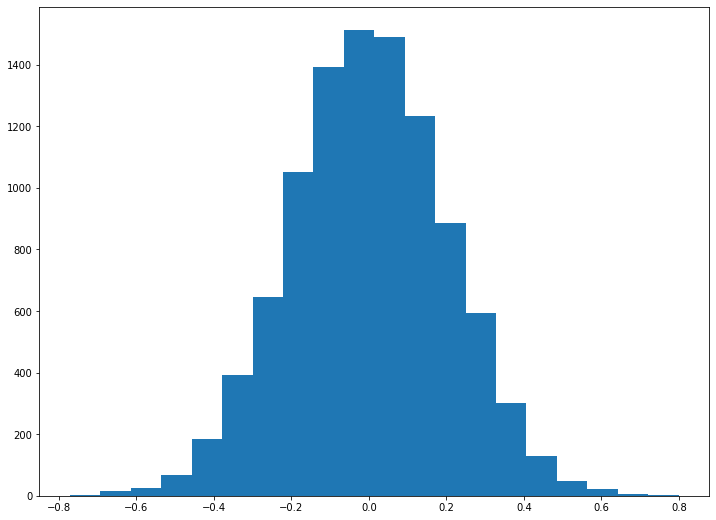

In [108]:
means = []
for _ in range(10000):  
    b = norm.rvs(1, 0.2)
    samples = norm.rvs(b, size=10000) - 1
    means.append(samples.mean())

print(np.mean(means))
print(np.std(means))
plt.hist(means, bins=20);

Обычно считают, что статистическая и систематическая ошибки нескоррелированы и нередко указываются по отдельности. Определить общую ошибку можно как 

$$
\sigma = \sqrt{\sigma^2_{stat} + \sigma^2_{sys}}
$$